In [104]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor,
                              ExtraTreesRegressor, StackingRegressor)

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (brier_score_loss, accuracy_score,
                             log_loss, mean_squared_error, 
                             mean_absolute_error)
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

from utils import get_season_pace, get_season_eff, GameElo, elo_predict

In [3]:
# the folders containing data files
data_folder = './kaggle_data/'
pom_folder = './kaggle_data/ken_pom_stats/'

In [4]:
mens_sp = pd.read_csv(f'{data_folder}MTeamSpellings.csv', encoding='latin-1')
mens_teams = pd.read_csv(f'{data_folder}MTeams.csv')
mens_reg = pd.read_csv(f'{data_folder}MRegularSeasonCompactResults.csv')
mens_det = pd.read_csv(f'{data_folder}MRegularSeasonDetailedResults.csv')
mens_seed = pd.read_csv(f'{data_folder}MNCAATourneySeeds.csv')
tourney_df = pd.read_csv(f'{data_folder}MNCAATourneyCompactResults.csv')
sec_tourn_df = pd.read_csv(f'{data_folder}MSecondaryTourneyCompactResults.csv')
pretourney_odds = pd.read_csv(f'{data_folder}ncaa_mens_odds.csv')
this_yr_odds = pd.read_csv(f'{data_folder}this_yr_pretourney.csv')

tourney_teams = list(set(pd.concat([tourney_df['WTeamID'], tourney_df['LTeamID']])))
mens_team_dict = mens_teams.set_index('TeamID')['TeamName'].to_dict()

In [5]:
winners = (
    mens_reg[['WTeamID', 'LTeamID', 'WLoc', 'Season']]
    .copy()
    .rename(columns={
        'WTeamID' : 'team_a',
        'LTeamID' : 'team_b',
        'WLoc' : 'home'})
)
winners['team_a_win'] = 1
winners['home'] = winners['home'].map({'H' : 1, 'N' : 0, 'A' : -1})

losers = (
    mens_reg[['LTeamID', 'WTeamID', 'WLoc', 'Season']]
    .copy()
    .rename(columns={
        'LTeamID' : 'team_a',
        'WTeamID' : 'team_b',
        'WLoc' : 'home'})
)

losers['team_a_win'] = 0
losers['home'] = losers['home'].map({'A' : 1, 'N' : 0, 'H' : -1})

In [6]:
test_df = pd.concat([winners, losers])
cond_tourney = tourney_df[['Season', 'WTeamID', 'LTeamID', 'WLoc']].copy()

In [7]:
cond_tourney.columns = ['Season', 'team_a', 'team_b', 'home']
cond_tourney['home'] = cond_tourney['home'].map({'H' : 1, 'N' : 0, 'A' : -1})

In [8]:
test_df = pd.concat([winners, losers])
test_df = test_df[test_df['Season'] == 2019].copy()

model_df = pd.get_dummies(test_df, columns=['team_a', 'team_b', 'home'])

X = model_df.drop(columns=['team_a_win', 'Season']).copy()
y = model_df['team_a_win']

lr = LogisticRegression()

lr.fit(X, y)

LogisticRegression()

In [199]:
coefs = pd.Series(lr.coef_[0]).round(2)
cols = X.columns

model_result = pd.DataFrame({'col' : cols, 'coef' : coefs}).sort_values(by='coef', ascending=False)

model_result[model_result['col'].str.contains('team_a')]

,col,coef
259,team_a_1424,2.94
11,team_a_1116,2.36
103,team_a_1231,2.27
180,team_a_1326,2.24
171,team_a_1314,2.09
...,...,...
136,team_a_1271,-1.99
138,team_a_1273,-2.11
119,team_a_1251,-2.23
5,team_a_1109,-2.36


In [13]:
win_cols = [x for x in mens_det.columns if x.startswith('W')]
win_cols.append('Season')
win_cols.append('DayNum')
lose_cols = [x for x in mens_det.columns if x.startswith('L')]
lose_cols.append('Season')
lose_cols.append('DayNum')

other_cols = ['Season', 'DayNum']

win_det = mens_det[win_cols].copy()
lose_det = mens_det[lose_cols].copy()
win_det.columns = [x[1:] if x not in other_cols else x for x in win_det.columns]
lose_det.columns = [x[1:] if x not in other_cols else x for x in lose_det.columns]

season_stats = (
    pd.concat([win_det, lose_det])
    .sort_values(by=['Season', 'DayNum'])
    .reset_index(drop=True)
    .drop(columns='Loc')
)

Mseason_sums = (
    season_stats
    .groupby(['Season', 'TeamID'])
    .sum()
    .reset_index()
    .drop(columns=['DayNum'])
)

Mseason_sums['3PRate'] = Mseason_sums['FGA3'].div(Mseason_sums['FGA']).round(3)
Mseason_sums['FGA2'] = Mseason_sums['FGA'].sub(Mseason_sums['FGA3'])
Mseason_sums['FGM2'] = Mseason_sums['FGM'].sub(Mseason_sums['FGM3'])
Mseason_sums['eFG'] = (Mseason_sums['FGM2'] + (1.5 * Mseason_sums['FGM3']))/ Mseason_sums['FGA']
Mseason_sums['3Perc'] = Mseason_sums['FGM3'].div(Mseason_sums['FGA3']).round(3)
Mseason_sums['2Perc'] = Mseason_sums['FGM2'].div(Mseason_sums['FGA2']).round(3)
Mseason_sums['FTr'] = Mseason_sums['FTA'].div(Mseason_sums['FGA'])
Mseason_sums['TOVperc'] = Mseason_sums['TO'] / (Mseason_sums['FGA'] + Mseason_sums['FTA'] * 0.44 + Mseason_sums['TO'])

Mseason_sums = Mseason_sums[['Season', 'TeamID', '3PRate', 'FTr', 'eFG', '3Perc', '2Perc', 'TOVperc']].round(3).copy()
Mseason_sums.columns = Mseason_sums.columns.str.lower()

In [14]:
mens_det['WPoss'] = mens_det['WFGA'] - mens_det['WOR'] + mens_det['WTO'] + (0.475 * mens_det['WFTA'])
mens_det['LPoss'] = mens_det['LFGA'] - mens_det['LOR'] + mens_det['LTO'] + (0.475 * mens_det['LFTA'])
mens_det['WPer100'] = (mens_det['WScore'] / mens_det['WPoss']) * 100
mens_det['LPer100'] = (mens_det['LScore'] / mens_det['LPoss']) * 100

In [15]:
mens_season_eff_dict = {}

for s in mens_det.Season.unique():
    df_ = get_season_eff(season=s, df=mens_det, teams_dict=mens_team_dict)
    mens_season_eff_dict[s] = df_

In [16]:
mens_season_pace_dict = {}

for s in mens_det.Season.unique():
    df_ = get_season_pace(season=s, df=mens_det)
    mens_season_pace_dict[s] = df_

In [17]:
# creating an alternate spelling dict and adding seeded teams
mens_sp_dict = mens_sp.set_index('TeamNameSpelling')['TeamID'].to_dict()

mens_sp_dict['ut rio grande valley'] = 1410
mens_sp_dict['liu'] = 1254
mens_sp_dict['illinois chicago'] = 1227
mens_sp_dict['texas a&m corpus chris'] = 1394
mens_sp_dict['louisiana lafayette'] = 1418
mens_sp_dict['southeast missouri st.'] = 1369
mens_sp_dict['southwest missouri st.'] = 1283
mens_sp_dict['cal st. bakersfield'] = 1167
mens_sp_dict['tennessee martin'] = 1404
mens_sp_dict['louisiana monroe'] = 1419
mens_sp_dict['arkansas little rock'] = 1114
mens_sp_dict['st. francis ny'] = 1383
mens_sp_dict['st. francis pa'] = 1384
mens_sp_dict['mississippi valley st.'] = 1290
mens_sp_dict['arkansas pine bluff'] = 1115

In [18]:
# reformatting the pretourney odds from sportsoddshistory.com so the
# implied probabilities can be added to the relevant dataframes

pretourney_odds['small_team'] = pretourney_odds.team.str.lower()
pretourney_odds['small_team'] = pretourney_odds['small_team'].str.strip()
pretourney_odds['teamid'] = [mens_sp_dict[x] if x in mens_sp_dict else -99 for x in pretourney_odds.small_team]
pretourney_odds['season'] = pretourney_odds['season'] + 1

pretourney_odds['implied_probability'] = (
    np.where(
        ((pretourney_odds['season'] < 2022) & (pretourney_odds['odds_int'] == 0)),
         0.0025,
         pretourney_odds['implied_probability']
    )
)           

pretourney_odds = pretourney_odds[['teamid', 'season', 'implied_probability']].copy()

In [19]:
# doing the same as above to this year's probabilities 

this_yr_odds['small_team'] = this_yr_odds.team.str.lower()
this_yr_odds['small_team'] = this_yr_odds['small_team'].str.strip()
this_yr_odds['teamid'] = [mens_sp_dict[x] if x in mens_sp_dict else -99 for x in this_yr_odds.small_team]
this_yr_odds['season'] = this_yr_odds['season'] + 1
       
# note i did not fill in nans with a negligible value because there aren't any
# the NaNs appear later on and are filled in there (mens_submission)
this_yr_odds = this_yr_odds[['teamid', 'season', 'implied_probability']].copy()

In [20]:
# kpom's summary statistics for each season (2003-2023)

pomdf = pd.DataFrame()

for file in os.listdir(f'{pom_folder}'):
    
    if 'roster' not in file:
        df_ = pd.read_csv(f'{pom_folder}{file}')
        pomdf = pd.concat([pomdf, df_], axis=0)

pomdf.reset_index(inplace=True, drop=True)
pomdf.columns = pomdf.columns.str.lower()
pomdf['teamname'] = pomdf['teamname'].str.lower().str.strip()
pomdf['teamid'] = pomdf['teamname'].map(mens_sp_dict)

pomdf = pomdf[pomdf['teamid'].isin(tourney_teams)].copy()

print('null teamid where seed >16:', pomdf[pomdf['seed'] >= 16]['teamid'].isnull().sum())

null teamid where seed >16: 0


In [21]:
# adding my estimates of pace, oeff, and deff (ridge regression on each season)
# to the pomdf dataframe 

my_paces = []

for x, y in zip(pomdf.season, pomdf.teamid):
    
    try:
        value = mens_season_pace_dict[x].loc[y]['pace']
        my_paces.append(value)
    except:
        my_paces.append(-99)
        
my_off_eff = []

for x, y in zip(pomdf.season, pomdf.teamid):
    
    try:
        value_ = mens_season_eff_dict[x].loc[y]['coef']
        my_off_eff.append(value_)
    except:
        my_off_eff.append(-99)
        
my_def_eff = []

for x, y in zip(pomdf.season, pomdf.teamid):
    
    try:
        value_ = mens_season_eff_dict[x].loc[y]['coef_def']
        my_def_eff.append(value_)
    except:
        my_def_eff.append(-99)

In [22]:
pomdf['my_pace'] = np.array(my_paces).round(1)
pomdf['my_off'] = np.array(my_off_eff)
pomdf['my_def'] = np.array(my_def_eff)
pomdf['my_total'] = pomdf['my_off'] + (-1 * pomdf['my_def'])

In [25]:
# calculating ELO using the mens regular season data. it has more
# data to work with

elo_dicts = {}

for s in mens_reg.Season.unique():
    
    df_ = mens_reg[mens_reg['Season'] == s].copy()
    elo_season = GameElo(df=df_, base_k=75)
    elo_season.process_elo()
    elo_dicts[s] = [elo_season.elo_dict,
                    elo_season.winner_probs,
                    elo_season.winner_elo,
                    elo_season.loser_elo]  

elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processe

In [30]:
team_filter = (mens_det['WTeamID'].isin(tourney_teams)) & (mens_det['LTeamID'].isin(tourney_teams))

mens_det = mens_det[team_filter].copy()

In [31]:
# reorganizing tourney data

team_pairs = tourney_df[['WTeamID', 'LTeamID']].values
idx = np.random.randint(0, team_pairs.shape[1], team_pairs.shape[0])

tourney_df['team_one'] = [x[0] for x in np.take_along_axis(team_pairs, idx[:, None], 1)]
tourney_df['team_two'] = (
    np.where(tourney_df['team_one'] == tourney_df['WTeamID'],
             tourney_df['LTeamID'],
             tourney_df['WTeamID']
            )
)

tourney_df['team_one_score'] = (
    np.where(tourney_df['team_one'] == tourney_df['WTeamID'],
             tourney_df['WScore'],
             tourney_df['LScore']
            )
)

tourney_df['team_two_score'] = (
    np.where(tourney_df['team_two'] == tourney_df['WTeamID'],
             tourney_df['WScore'],
             tourney_df['LScore']
            )
)


tourney_df['score_diff'] = tourney_df['team_one_score'].sub(tourney_df['team_two_score'])
tourney_df['team_one_win'] = (
    np.where(tourney_df['team_one_score'] > tourney_df['team_two_score'],
             1,
             0)
)

tourney_df = (
    tourney_df
    .merge(pomdf,
           how='left',
           left_on=['Season', 'team_one'],
           right_on=['season', 'teamid'],)
    .drop(columns=['teamid'])
)

tourney_df.columns = ['team_one_' + x if x in pomdf.columns else x for x in tourney_df.columns]


m_tourney_df = (
    tourney_df
    .merge(pomdf,
           how='left',
           left_on=['Season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

m_tourney_df.columns = ['team_two_' + x if x in pomdf.columns else x for x in m_tourney_df.columns]

m_tourney_df['team_one_win'] = (
    np.where(m_tourney_df['team_one_score'] > m_tourney_df['team_two_score'],
             1,
             0)
)

In [32]:
# selecting a column w/efficiency stats to use to drop the others
m_tourney_df.dropna(subset=['team_two_my_off'], inplace=True)

In [33]:
m_tourney_df = (
    m_tourney_df
    .merge(pretourney_odds,
           how='left',
           left_on=['Season', 'team_one'],
           right_on=['season', 'teamid'])
    .drop(columns=['season', 'teamid'])
    .rename(columns={'implied_probability' : 'team_one_implied_proba'})
)

In [34]:
m_tourney_df = (
    m_tourney_df
    .merge(pretourney_odds,
           how='left',
           left_on=['Season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['season', 'teamid'])
    .rename(columns={'implied_probability' : 'team_two_implied_proba'})
)

In [35]:
m_tourney_df = (
    m_tourney_df
    .merge(Mseason_sums,
           how='left',
           left_on=['Season', 'team_one'],
           right_on=['season', 'teamid'])
    .drop(columns=['season', 'teamid'])
)

m_tourney_df.columns = ['team_one_' + x if x in Mseason_sums.columns else x for x in m_tourney_df.columns]

In [42]:
preds = []
t1_elos = []
t2_elos = []


for s, o, t in zip(m_tourney_df['Season'], m_tourney_df['team_one'], m_tourney_df['team_two']):
    
    t1_elo = elo_dicts[s][0][o]
    t2_elo = elo_dicts[s][0][t]
    pred = elo_predict(t1_elo, t2_elo)
    preds.append(pred)
    t1_elos.append(t1_elo)
    t2_elos.append(t2_elo)
    
m_tourney_df['elo_pred'] = preds
m_tourney_df['t1_elo'] = t1_elos
m_tourney_df['t2_elo'] = t2_elos

In [43]:
m_tourney_df = (
    m_tourney_df
    .merge(Mseason_sums,
           how='left',
           left_on=['Season', 'team_two'],
           right_on=['season', 'teamid'])
)

m_tourney_df.columns = ['team_two_' + x if x in Mseason_sums.columns else x for x in m_tourney_df.columns]

In [44]:
m_tourney_df[['team_one_implied_proba', 'team_two_implied_proba']] =(
    m_tourney_df[['team_one_implied_proba', 'team_two_implied_proba']].fillna(0.004)
)

In [92]:
m_tourney_df['elo_diff'] = m_tourney_df['t1_elo'].sub(m_tourney_df['t2_elo'])

In [101]:
model_cols = ['team_one_ranktempo', 'team_one_adjtempo', 'team_one_rankadjtempo',
              'team_one_rankoe', 'team_one_adjoe', 'team_one_adjde', 
              'team_one_rankadjde', 'team_one_adjem','team_one_rankadjem', 
              'team_two_adjtempo', 'team_two_rankadjtempo','team_two_adjoe',
              'team_two_rankadjoe', 'team_two_adjde','team_two_rankadjde', 
              'team_two_adjem', 'team_two_rankadjem', 'team_one_my_total',
              'team_two_my_total', 'team_one_implied_proba', 'team_two_implied_proba',
              't1_elo', 't2_elo']

target = 'team_one_win'

In [102]:
linear_model = ['team_one_rankadjde', 'team_one_adjem','team_one_rankadjem', 
              'team_two_adjoe', 'team_two_rankadjoe', 'team_two_adjem', 
              'team_two_rankadjem', 'team_one_my_total','team_two_my_total']

In [103]:
reg_target = 'score_diff'

ridge_model = RidgeCV(alphas=[100, 500, 700])
lasso_model = LassoCV(alphas=[0.1, 0.2, 0.5, 1])
neighbors_model = KNeighborsRegressor(n_neighbors=3)
rf_model = RandomForestRegressor()
gbm_model = GradientBoostingRegressor()
xtrees_model = ExtraTreesRegressor()
stack_model = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                            ('lasso', LassoCV()),
                                            ('kneigh', KNeighborsRegressor()),
                                            ('gbm', GradientBoostingRegressor()),
                                            ('rf', RandomForestRegressor()),
                                            ('xtrees', ExtraTreesRegressor())]
                               )

X = m_tourney_df[linear_model]
y = m_tourney_df[reg_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


stack_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)
xtrees_model.fit(X_train, y=y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
neighbors_model.fit(X_train, y_train)

print('lasso MAE:', mean_absolute_error(y_test, lasso_model.predict(X_test)))
print('ridge MAE:', mean_absolute_error(y_test, ridge_model.predict(X_test)))
print('neighbors MAE:', mean_absolute_error(y_test, neighbors_model.predict(X_test)))
print('gbm MAE:', mean_absolute_error(y_test, gbm_model.predict(X_test)))
print('rf MAE:', mean_absolute_error(y_test, rf_model.predict(X_test)))
print('xtree MAE:', mean_absolute_error(y_test, xtrees_model.predict(X_test)))
print('stacker MAE:', mean_absolute_error(y_test, stack_model.predict(X_test)))

lasso MAE: 9.208635507969193
ridge MAE: 9.208209170778085
neighbors MAE: 10.379814077025234
gbm MAE: 9.472263351545672
rf MAE: 9.614382470119523
xtree MAE: 9.882988047808764
stacker MAE: 9.22888490917729


<Axes: ylabel='score_diff'>

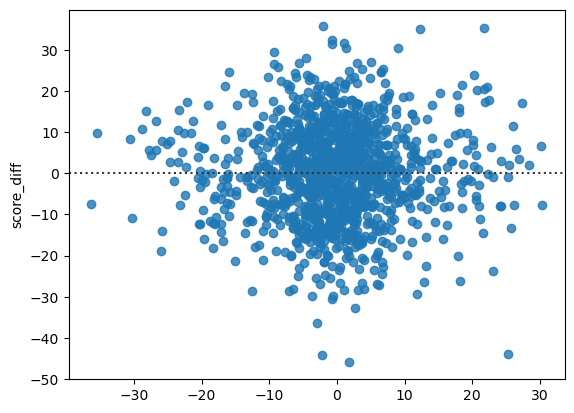

In [50]:
sns.residplot(x=stack_model.predict(X), y=y)

In [51]:
# identifying rank columns and converting them to categories
# the goal was to take advantage of native cat handling
rank_cols = [x for x in tourney_df.columns if 'rank' in x]
m_tourney_df[rank_cols] = m_tourney_df[rank_cols].astype('category')

# predicting the game spread to use as an input to the win probability
# model
m_tourney_df['pred_diff'] = ridge_model.predict(m_tourney_df[linear_model])
model_cols.extend(['pred_diff'])

In [105]:
gbm_cl_model = GradientBoostingClassifier(random_state=35, max_depth=3)
hist_cl_model = HistGradientBoostingClassifier(random_state=62, max_depth=3)

params = {
    'max_depth' : [2, 3],
    'min_samples_leaf' : [26, 27, 29],
    'max_iter' : [40, 42, 44]
}

gridsearch = GridSearchCV(model, param_grid=params, cv=10, scoring='neg_log_loss')

X = m_tourney_df[model_cols].copy()
y = m_tourney_df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

gbm_cl_model.fit(X_train, y_train)
hist_cl_model.fit(X_train, y_train)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=HistGradientBoostingClassifier(max_depth=3,
                                                      random_state=62),
             param_grid={'max_depth': [2, 3], 'max_iter': [40, 42, 44],
                         'min_samples_leaf': [26, 27, 29]},
             scoring='neg_log_loss')

In [117]:
# creating a calibrated classifier
cal_model = CalibratedClassifierCV(estimator=gridsearch, cv=5)
cal_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=GridSearchCV(cv=10,
                                              estimator=HistGradientBoostingClassifier(max_depth=3,
                                                                                       random_state=62),
                                              param_grid={'max_depth': [2, 3],
                                                          'max_iter': [40, 42,
                                                                       44],
                                                          'min_samples_leaf': [26,
                                                                               27,
                                                                               29]},
                                              scoring='neg_log_loss'))

In [119]:
log_loss(y_test, cal_model.predict_proba(X_test)[:,1])

0.5329861800778238

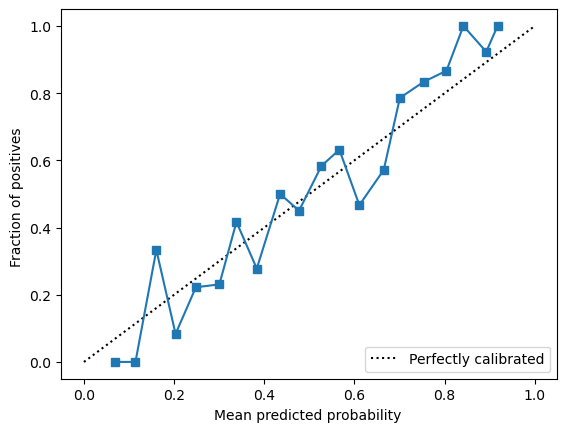

In [120]:
y_probs = cal_model.predict_proba(X_test[model_cols]).round(3)[:,1]

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=22)

disp = CalibrationDisplay(prob_true, prob_pred, y_probs)

disp.plot()

In [121]:
brier_score_loss(y_test, cal_model.predict_proba(X_test[model_cols]).round(3)[:,1])

0.17920061354581673

In [122]:
X_test['preds'] = cal_model.predict_proba(X_test).round(3)[:,1]
X_test['result'] = y_test

In [42]:
mens_submission = pd.read_csv(f'{data_folder}SampleSubmission2023.csv')

mens_submission['team_one'] = [int(x[5:9]) for x in mens_submission.ID]
mens_submission['team_two'] = [int(x[10:15]) for x in mens_submission.ID]
mens_submission['season'] = 2023

# getting a list of this year's teams
mens_teams_thisyr = list(mens_seed[mens_seed['Season'] == 2023]['TeamID'].unique())

# limiting the pool to this year's teams
condition = ((mens_submission['team_one'].isin(mens_teams_thisyr)) & 
             (mens_submission['team_two'].isin(mens_teams_thisyr))
            )

mens_submission = mens_submission[condition].copy()

# getting ELO predictions
elo_preds = []

for o, t in zip(mens_submission['team_one'], mens_submission['team_two']):

        proba_ = elo_predict(elo_dicts[2023][0][o], elo_dicts[2023][0][t])
        elo_preds.append(proba_)
        
mens_submission['elo_pred'] = elo_preds

In [61]:
# creating a dictionary of teamid -> implied probs. note that if a team does not appear
# i assign a negligible probability. teams without vegas odds won't be contenders

thisyr_oddsdict = this_yr_odds.set_index('teamid')['implied_probability'].to_dict()

mens_submission['team_one_implied_proba'] = (
    [thisyr_oddsdict[x] if x in thisyr_oddsdict else 0.0025 for x in mens_submission['team_one']]
)

mens_submission['team_two_implied_proba'] = (
    [thisyr_oddsdict[x] if x in thisyr_oddsdict else 0.0025 for x in mens_submission['team_two']]
)

In [45]:
# lists of columns from ken pom's df and my own stats that were used
# to train the model

pom_cols = ['season', 'teamid', 'ranktempo', 'adjtempo', 'rankadjtempo', 'rankoe', 
            'adjoe', 'adjde', 'rankadjde', 'adjem', 'rankadjem', 'adjtempo',
            'rankadjtempo', 'rankadjoe']

my_cols = ['team_one_my_total', 'team_two_my_total']

In [46]:
# limiting the pom_cols to non-duplicates because i made an error earlier

pom_cols = list(set(pom_cols))
pom_model_df = pomdf[pom_cols].copy()

mens_submission = (
    mens_submission
    .merge(pom_model_df,
           how='left',
           left_on=['season', 'team_one'],
           right_on=['season', 'teamid'],)
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_one_' + x if x in pom_model_df.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_one_season' : 'season'}, inplace=True)

mens_submission = (
    mens_submission
    .merge(pom_model_df,
           how='left',
           left_on=['season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_two_' + x if x in pom_model_df.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_two_season' : 'season'}, inplace=True)

In [47]:
my_season_stats = mens_season_eff_dict[2023].reset_index()
my_season_stats['my_total'] = my_season_stats['coef'] + (-1 * my_season_stats['coef_def'])
my_season_stats.drop(columns=['coef', 'coef_def'], inplace=True)

In [48]:
mens_submission = (
    mens_submission
    .merge(my_season_stats,
           how='left',
           left_on=['season', 'team_one'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_one_' + x if x in my_season_stats.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_one_season' : 'season'}, inplace=True)

mens_submission = (
    mens_submission
    .merge(my_season_stats,
           how='left',
           left_on=['season', 'team_two'],
           right_on=['season', 'teamid'])
    .drop(columns=['teamid'])
)

mens_submission.columns = ['team_two_' + x if x in my_season_stats.columns else x for x in mens_submission.columns]
mens_submission.rename(columns={'team_two_season' : 'season'}, inplace=True)

In [49]:
# filling in nan values using column quantiles. in the rank columns 
# i use 0.8, and in the numeric columns 0.2

ranked_cols = [x for x in mens_submission.columns if 'rank' in x]
not_ranked_cols = [x for x in mens_submission.columns if x not in ranked_cols]

quan_vals = mens_submission[ranked_cols].quantile(0.8)
non_ranked_quan_vals = mens_submission[not_ranked_cols].quantile(0.2)

mens_submission[ranked_cols] = mens_submission[ranked_cols].fillna(quan_vals)
mens_submission[not_ranked_cols] = mens_submission[not_ranked_cols].fillna(non_ranked_quan_vals)

C:\Users\yaobv\AppData\Local\Temp\ipykernel_10572\1700174904.py:8: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  non_ranked_quan_vals = mens_submission[not_ranked_cols].quantile(0.2)


In [63]:
mens_submission['pred_diff'] = ridge_model.predict(mens_submission[linear_model])
mens_submission['model_pred'] = gridsearch.predict_proba(mens_submission[model_cols])[:,1]

mens_submission['Pred'] = mens_submission['model_pred']

In [94]:
# getting this year's sixteenth seed to artificially change the first round 
# win probability. if i'd had more time i would have incorporated this information
# directly into the model
mens_seeds_2023 = mens_seed[mens_seed['Season'] == 2023].copy()
men_Wsixteen_seeds = mens_seeds_2023[mens_seeds_2023['Seed'].str.contains('16')]['TeamID'].to_list()

mens_submission['Pred'] = (
    np.where(mens_submission['team_one'].isin(men_Wsixteen_seeds),
             0,
             mens_submission['Pred'])
)

mens_submission['Pred'] = (
    np.where(mens_submission['team_two'].isin(men_Wsixteen_seeds),
             1,
             mens_submission['Pred'])
)

In [64]:
womens_teams = pd.read_csv(f'{data_folder}WTeams.csv')
womens_conf = pd.read_csv(f'{data_folder}WTeamConferences.csv')
womens_reg = pd.read_csv(f'{data_folder}WRegularSeasonCompactResults.csv')
womens_det = pd.read_csv(f'{data_folder}WRegularSeasonDetailedResults.csv')
womens_seed = pd.read_csv(f'{data_folder}WNCAATourneySeeds.csv')
womens_tourn = pd.read_csv(f'{data_folder}WNCAATourneyCompactResults.csv')

# creating a dictionary of womens team ids to be used later
womens_tourn_teams = list(set(pd.concat([womens_tourn['WTeamID'], womens_tourn['LTeamID']])))
womens_team_dict = womens_teams.set_index('TeamID')['TeamName'].to_dict()

In [65]:
win_cols = [x for x in womens_det.columns if x.startswith('W')]
win_cols.append('Season')
win_cols.append('DayNum')
lose_cols = [x for x in womens_det.columns if x.startswith('L')]
lose_cols.append('Season')
lose_cols.append('DayNum')

other_cols = ['Season', 'DayNum']

win_det = womens_det[win_cols].copy()
lose_det = womens_det[lose_cols].copy()
win_det.columns = [x[1:] if x not in other_cols else x for x in win_det.columns]
lose_det.columns = [x[1:] if x not in other_cols else x for x in lose_det.columns]

season_stats = (
    pd.concat([win_det, lose_det])
    .sort_values(by=['Season', 'DayNum'])
    .reset_index(drop=True)
    .drop(columns='Loc')
)

Wseason_sums = (
    season_stats
    .groupby(['Season', 'TeamID'])
    .sum()
    .reset_index()
    .drop(columns=['DayNum'])
)

Wseason_sums['3PRate'] = Wseason_sums['FGA3'].div(Wseason_sums['FGA']).round(3)
Wseason_sums['FGA2'] = Wseason_sums['FGA'].sub(Wseason_sums['FGA3'])
Wseason_sums['FGM2'] = Wseason_sums['FGM'].sub(Wseason_sums['FGM3'])
Wseason_sums['eFG'] = (Wseason_sums['FGM2'] + (1.5 * Wseason_sums['FGM3']))/ Wseason_sums['FGA']
Wseason_sums['3Perc'] = Wseason_sums['FGM3'].div(Wseason_sums['FGA3']).round(3)
Wseason_sums['2Perc'] = Wseason_sums['FGM2'].div(Wseason_sums['FGA2']).round(3)
Wseason_sums['FTr'] = Wseason_sums['FTA'].div(Wseason_sums['FGA'])
Wseason_sums['TOVperc'] = Wseason_sums['TO'] / (Wseason_sums['FGA'] + Wseason_sums['FTA'] * 0.44 + Wseason_sums['TO'])

Wseason_sums = Wseason_sums[['Season', 'TeamID', '3PRate', 'FTr', 'eFG', '3Perc', '2Perc', 'TOVperc']].round(3).copy()

Possessions = FGA-OR+TO+.475*FTA

In [66]:
womens_det['WPoss'] = womens_det['WFGA'] - womens_det['WOR'] + womens_det['WTO'] + (0.475 * womens_det['WFTA'])
womens_det['LPoss'] = womens_det['LFGA'] - womens_det['LOR'] + womens_det['LTO'] + (0.475 * womens_det['LFTA'])
womens_det['WPer100'] = (womens_det['WScore'] / womens_det['WPoss']) * 100
womens_det['LPer100'] = (womens_det['LScore'] / womens_det['LPoss']) * 100

In [67]:
# filtering out overtime games to build season-team level models
womens_det = womens_det[womens_det['NumOT'] == 0].copy()

In [68]:
womens_team_filter = ((womens_det['WTeamID'].isin(womens_tourn_teams) & 
                       (womens_det['LTeamID'].isin(womens_tourn_teams)))
                     )

womens_det = womens_det[womens_team_filter].copy()

In [69]:
womens_reg_filter = (
    ((womens_reg['WTeamID'].isin(womens_tourn_teams)) & (womens_reg['LTeamID'].isin(womens_tourn_teams)))
)

womens_reg_filtered = womens_reg[womens_reg_filter].copy()
womens_reg_filtered.reset_index(inplace=True, drop=True)

In [70]:
womens_season_eff_dict = {}

for s in womens_det.Season.unique():
    df_ = get_season_eff(season=s, df=womens_det, teams_dict=womens_team_dict)
    df_['off_eff_rank'] = df_['coef'].rank(ascending=False)
    df_['def_eff_rank'] = df_['coef_def'].rank(ascending=False)
    df_['my_total'] = df_['coef'] + (-1 * df_['coef_def'])
    womens_season_eff_dict[s] = df_

In [71]:
womens_season_pace_dict = {}

for s in womens_det.Season.unique():
    df_ = get_season_pace(season=s, df=womens_det)
    df_['pace_rank'] = df_['pace'].rank(ascending=False)
    womens_season_pace_dict[s] = df_

In [72]:
wteam_pairs = womens_reg_filtered[['WTeamID', 'LTeamID']].values
idx = np.random.randint(0, wteam_pairs.shape[1], wteam_pairs.shape[0])

womens_reg_filtered['team_one'] = [x[0] for x in np.take_along_axis(wteam_pairs, idx[:, None], 1)]


womens_reg_filtered['team_two'] = (
    np.where(womens_reg_filtered['WTeamID'] == womens_reg_filtered['team_one'],
             womens_reg_filtered['LTeamID'],
             womens_reg_filtered['WTeamID']
            )
)



womens_reg_filtered['team_one_score'] = (
    np.where(womens_reg_filtered['WTeamID'] == womens_reg_filtered['team_one'],
             womens_reg_filtered['WScore'],
             womens_reg_filtered['LScore']
            )
)

womens_reg_filtered['team_two_score'] = (
    np.where(womens_reg_filtered['WTeamID'] == womens_reg_filtered['team_one'],
             womens_reg_filtered['LScore'],
             womens_reg_filtered['WScore']
            )
)

womens_reg_filtered['team_one_win'] = (
    np.where(womens_reg_filtered['team_one_score'] > womens_reg_filtered['team_two_score'],
             1,
             0)
)

In [73]:
womens_elo_dicts = {}

for s in womens_reg.Season.unique():
    
    df_ = womens_reg[womens_reg['Season'] == s].copy()
    elo_season = GameElo(df=df_, base_k=82)
    elo_season.process_elo()
    womens_elo_dicts[s] = [elo_season.elo_dict, elo_season.winner_probs]  

elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully


In [74]:
# reorganizing womens tourney data

team_pairs = womens_tourn[['WTeamID', 'LTeamID']].values
idx = np.random.randint(0, team_pairs.shape[1], team_pairs.shape[0])

womens_tourn['team_one'] = [x[0] for x in np.take_along_axis(team_pairs, idx[:, None], 1)]
womens_tourn['team_two'] = (
    np.where(womens_tourn['team_one'] == womens_tourn['WTeamID'],
             womens_tourn['LTeamID'],
             womens_tourn['WTeamID']
            )
)

womens_tourn['team_one_score'] = (
    np.where(womens_tourn['team_one'] == womens_tourn['WTeamID'],
             womens_tourn['WScore'],
             womens_tourn['LScore']
            )
)

womens_tourn['team_two_score'] = (
    np.where(womens_tourn['team_two'] == womens_tourn['WTeamID'],
             womens_tourn['WScore'],
             womens_tourn['LScore']
            )
)


womens_tourn['score_diff'] = womens_tourn['team_one_score'].sub(womens_tourn['team_two_score'])
womens_tourn['team_one_win'] = (
    np.where(womens_tourn['team_one_score'] > womens_tourn['team_two_score'],
             1,
             0)
)

In [75]:
womens_preds = []

for s, o, t in zip(womens_tourn['Season'], womens_tourn['team_one'], womens_tourn['team_two']):

    t1_elo = womens_elo_dicts[s][0][o]
    t2_elo = womens_elo_dicts[s][0][t]
    pred = elo_predict(t1_elo, t2_elo)
    womens_preds.append(pred)
    
womens_tourn['elo_preds'] = womens_preds

In [76]:
team_1_paces = []
team_1_paceranks = []

team_2_paces = []
team_2_paceranks = []

team_1_totals = []
team_2_totals = []

for s, o, t in zip(womens_tourn['Season'], womens_tourn['team_one'], womens_tourn['team_two']):
    
    try:
        team_1_pace = womens_season_pace_dict[s].loc[o]['pace']
        team_1_pace_rank = womens_season_pace_dict[s].loc[o]['pace_rank']
        
        team_2_pace = womens_season_pace_dict[s].loc[t]['pace']
        team_2_pace_rank = womens_season_pace_dict[s].loc[t]['pace_rank']
        
        team_1_my_total = womens_season_eff_dict[s].loc[o]['my_total']
        team_2_my_total = womens_season_eff_dict[s].loc[t]['my_total']

        team_1_paces.append(team_1_pace)
        team_1_paceranks.append(team_1_pace)
        team_2_paces.append(team_2_pace)
        team_2_paceranks.append(team_2_pace_rank)
        team_1_totals.append(team_1_my_total)
        team_2_totals.append(team_2_my_total)
        
    except:
        team_1_paces.append(np.nan)
        team_1_paceranks.append(np.nan)
        team_2_paces.append(np.nan)
        team_2_paceranks.append(np.nan)
        team_1_totals.append(np.nan)
        team_2_totals.append(np.nan)

In [77]:
womens_tourn['team_one_pace'] = team_1_paces
womens_tourn['team_one_pace_rank'] = team_1_paceranks
womens_tourn['team_one_my_total'] = team_1_totals

womens_tourn['team_two_pace'] = team_2_paces
womens_tourn['team_two_pace_rank'] = team_2_paceranks
womens_tourn['team_two_my_total'] = team_2_totals

In [78]:
womens_model_cols = ['elo_preds', 'team_one_pace', 'team_one_pace_rank',
                     'team_one_my_total', 'team_two_pace', 'team_two_pace_rank',
                     'team_two_my_total']

In [79]:
womens_model = HistGradientBoostingClassifier()

womens_X = womens_tourn[womens_model_cols].copy()
womens_y = womens_tourn['team_one_win'].values

X_train, X_test, y_train, y_test = train_test_split(womens_X, womens_y, test_size=0.2, random_state=34)

In [80]:
womens_submission = pd.read_csv(f'{data_folder}SampleSubmission2023.csv')
womens_seeds = pd.read_csv(f'{data_folder}WNCAATourneySeeds.csv')

# getting a list of this year's teams
womens_teams_thisyr = list(womens_seed[womens_seed['Season'] == 2023]['TeamID'].unique())

womens_submission['team_one'] = [int(x[5:9]) for x in womens_submission.ID]
womens_submission['team_two'] = [int(x[10:15]) for x in womens_submission.ID]
womens_submission['season'] = 2023

# limiting the pool to this year's teams
condition = ((womens_submission['team_one'].isin(womens_teams_thisyr)) & 
             (womens_submission['team_two'].isin(womens_teams_thisyr))
            )

womens_submission = womens_submission[condition].copy()

In [81]:
womens_elo_preds = []

for o, t in zip(womens_submission['team_one'], womens_submission['team_two']):
    
    try:

        proba_ = elo_predict(womens_elo_dicts[2023][0][o], womens_elo_dicts[2023][0][t])
        womens_elo_preds.append(proba_)
        
    except:
        womens_elo_preds.append(0.5)
        
womens_submission['elo_pred'] = womens_elo_preds
womens_submission['Pred'] = womens_submission['elo_pred']

In [82]:
womens_seeds_2023 = womens_seeds[womens_seeds['Season'] == 2023].copy()

Wone_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('01')]['TeamID'].to_list()
Wsixteen_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('16')]['TeamID'].to_list()

womens_submission['Pred'] = (
    np.where(womens_submission['team_one'].isin(Wsixteen_seeds),
             0,
             womens_submission['Pred'])
)

womens_submission['Pred'] = (
    np.where(womens_submission['team_two'].isin(Wsixteen_seeds),
             1,
             womens_submission['Pred'])
)

C:\Users\yaobv\AppData\Local\Temp\ipykernel_10572\3358348523.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Wone_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('01')]['TeamID'].to_list()
C:\Users\yaobv\AppData\Local\Temp\ipykernel_10572\3358348523.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Wsixteen_seeds = womens_seeds_2023[womens_seeds['Seed'].str.contains('16')]['TeamID'].to_list()


<Axes: >

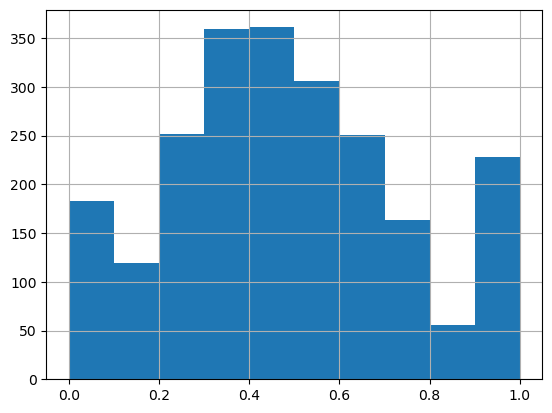

In [83]:
womens_submission['Pred'].hist()

In [106]:
# loading the sample to populate it 

full_submission = pd.read_csv(f'{data_folder}SampleSubmission2023.csv')

# limiting men's and women's submission df's
mens_submission_compact = mens_submission[['ID', 'Pred']].copy()
womens_submission_compact = womens_submission[['ID', 'Pred']].copy()

In [107]:
men_women_sub = pd.concat([mens_submission_compact, womens_submission_compact])

mwsubdict = men_women_sub.set_index('ID')['Pred'].to_dict()

full_submission['Pred'] = [mwsubdict[x] if x in mwsubdict else 0.5 for x in full_submission['ID']]

In [708]:
full_submission.to_csv('late_sub3.csv', index=False)

array([[<Axes: title={'center': 'Pred'}>]], dtype=object)

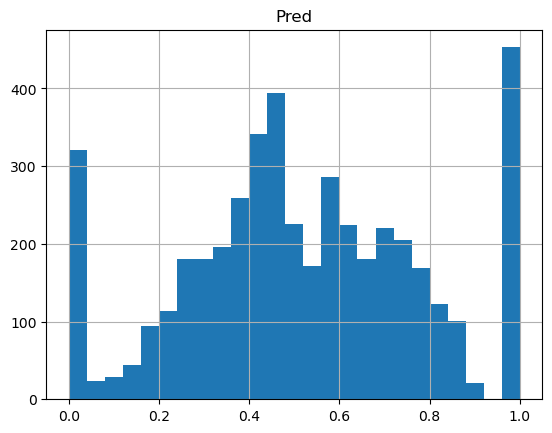

In [109]:
full_submission[full_submission['Pred'] != 0.5].hist(bins=25)

In [111]:
full_submission['team_a'] = [int(x[5:9]) for x in full_submission['ID']]
full_submission['team_b'] = [int(x[10:14]) for x in full_submission['ID']]

In [112]:
full_submission['team_a_name'] = (
    [mens_team_dict[x] if x in mens_team_dict else womens_team_dict[x] for x in full_submission.team_a]
)

In [113]:
full_submission['team_b_name'] = (
    [mens_team_dict[x] if x in mens_team_dict else womens_team_dict[x] for x in full_submission.team_b]
)

In [116]:
full_submission.query("team_a_name == 'Kennesaw'").sort_values(by='Pred').head(55)

,ID,Pred,team_a,team_b,team_a_name,team_b_name
40220,2023_1244_1417,0.162092,1244,1417,Kennesaw,UCLA
40200,2023_1244_1397,0.222402,1244,1397,Kennesaw,Tennessee
40149,2023_1244_1345,0.226061,1244,1345,Kennesaw,Purdue
40203,2023_1244_1400,0.243207,1244,1400,Kennesaw,Texas
40073,2023_1244_1266,0.274006,1244,1266,Kennesaw,Marquette
40191,2023_1244_1388,0.301904,1244,1388,Kennesaw,St Mary's CA
40165,2023_1244_1361,0.381625,1244,1361,Kennesaw,San Diego St
40079,2023_1244_1272,0.412649,1244,1272,Kennesaw,Memphis
40087,2023_1244_1280,0.429089,1244,1280,Kennesaw,Mississippi St
40204,2023_1244_1401,0.433048,1244,1401,Kennesaw,Texas A&M
